In [49]:
%load_ext autoreload
%autoreload 2

import os
import cv2
import IPython
import matplotlib
import matplotlib.pyplot as pyplot
import keras
from keras.models import load_model
import keras.saving
import keras.utils
import tensorflow as tf
import numpy as np

dataDir = "E:/Work/NonoGram/"

digitRecognizerModelFileName = f"{dataDir}/digitRecognizerMnist.keras"
digitRecognizer = load_model(digitRecognizerModelFileName)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read image

In [ ]:
#image = cv2.imread('E:/Work/NonoGram/Data/sample.png') 
#image = cv2.imread('E:/Work/NonoGram/Data/puzzle.jpg') 
image = cv2.imread('E:/Work/NonoGram/Data/wikipedia.png') 
#image = cv2.imread('E:/Work/NonoGram/Data/sample3.png') 
# image = cv2.imread('E:/Work/NonoGram/Data/sample4.png')  issues with grid lines (use thresh 50, 100) and then issues with recognizing the grid


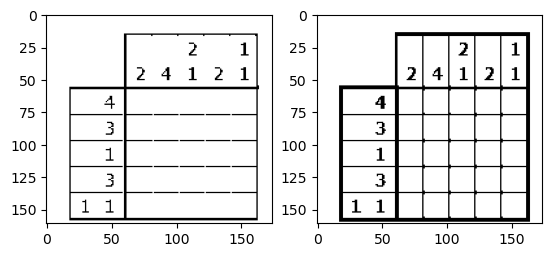

In [51]:
image_contours = image.copy()
image_contours = cv2.cvtColor(image_contours, cv2.COLOR_BGR2GRAY)
(_, image_contours) = cv2.threshold(image_contours, 10, 255, cv2.THRESH_BINARY)        # todo use 10 as bound

image_digits = image.copy()
#image_digits = cv2.GaussianBlur(image_digits, (1, 1), 0)
image_digits = cv2.cvtColor(image_digits, cv2.COLOR_BGR2GRAY)
(_, image_digits) = cv2.threshold(image_digits, 100, 255, cv2.THRESH_BINARY)
#imageCopy = cv2.dilate(imageCopy, (3,3), 1)
#imageCopy = cv2.GaussianBlur(imageCopy, (1, 1), 0)
#imageCopy = cv2.cvtColor(imageCopy, cv2.COLOR_BGR2GRAY)
#blurred = cv2.GaussianBlur(gray, (5, 5), 0)
#imageCopy = cv2.Canny(imageCopy, 50, 150)
#imageCopy = 255-imageCopy
#imageCopy = cv2.Canny(imageCopy, 50, 150)

pyplot.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
pyplot.imshow(image_contours, cmap="gray")
pyplot.subplot(1, 2, 2)
pyplot.imshow(image_digits, cmap="gray")


# Find left and right based on lines

11.0
[[[ 46 144]]

 [[ 47 144]]

 [[ 48 145]]

 [[ 48 151]]

 [[ 47 152]]

 [[ 46 152]]

 [[ 52 152]]

 [[ 50 152]]

 [[ 49 151]]

 [[ 49 143]]]
11.0
[[[ 48 143]]

 [[ 47 144]]

 [[ 46 144]]

 [[ 47 144]]

 [[ 48 145]]

 [[ 48 151]]

 [[ 47 152]]

 [[ 46 152]]

 [[ 52 152]]

 [[ 50 152]]

 [[ 49 151]]

 [[ 49 143]]]
20.0
[[[ 27 144]]

 [[ 28 144]]

 [[ 29 145]]

 [[ 29 151]]

 [[ 28 152]]

 [[ 27 152]]

 [[ 33 152]]

 [[ 32 152]]

 [[ 31 151]]

 [[ 31 143]]

 [[ 29 143]]

 [[ 28 144]]]
20.0
[[[ 29 143]]

 [[ 28 144]]

 [[ 27 144]]

 [[ 28 144]]

 [[ 29 145]]

 [[ 29 151]]

 [[ 28 152]]

 [[ 27 152]]

 [[ 33 152]]

 [[ 32 152]]

 [[ 31 151]]

 [[ 31 143]]]
378.0
[[[142 138]]

 [[143 137]]

 [[160 137]]

 [[161 138]]

 [[161 156]]

 [[160 157]]

 [[143 157]]

 [[142 156]]]
378.0
[[[142 138]]

 [[143 137]]

 [[160 137]]

 [[161 138]]

 [[161 156]]

 [[160 157]]

 [[143 157]]

 [[142 156]]]
378.0
[[[122 138]]

 [[123 137]]

 [[140 137]]

 [[141 138]]

 [[141 156]]

 [[140 157]]

 [[123 157

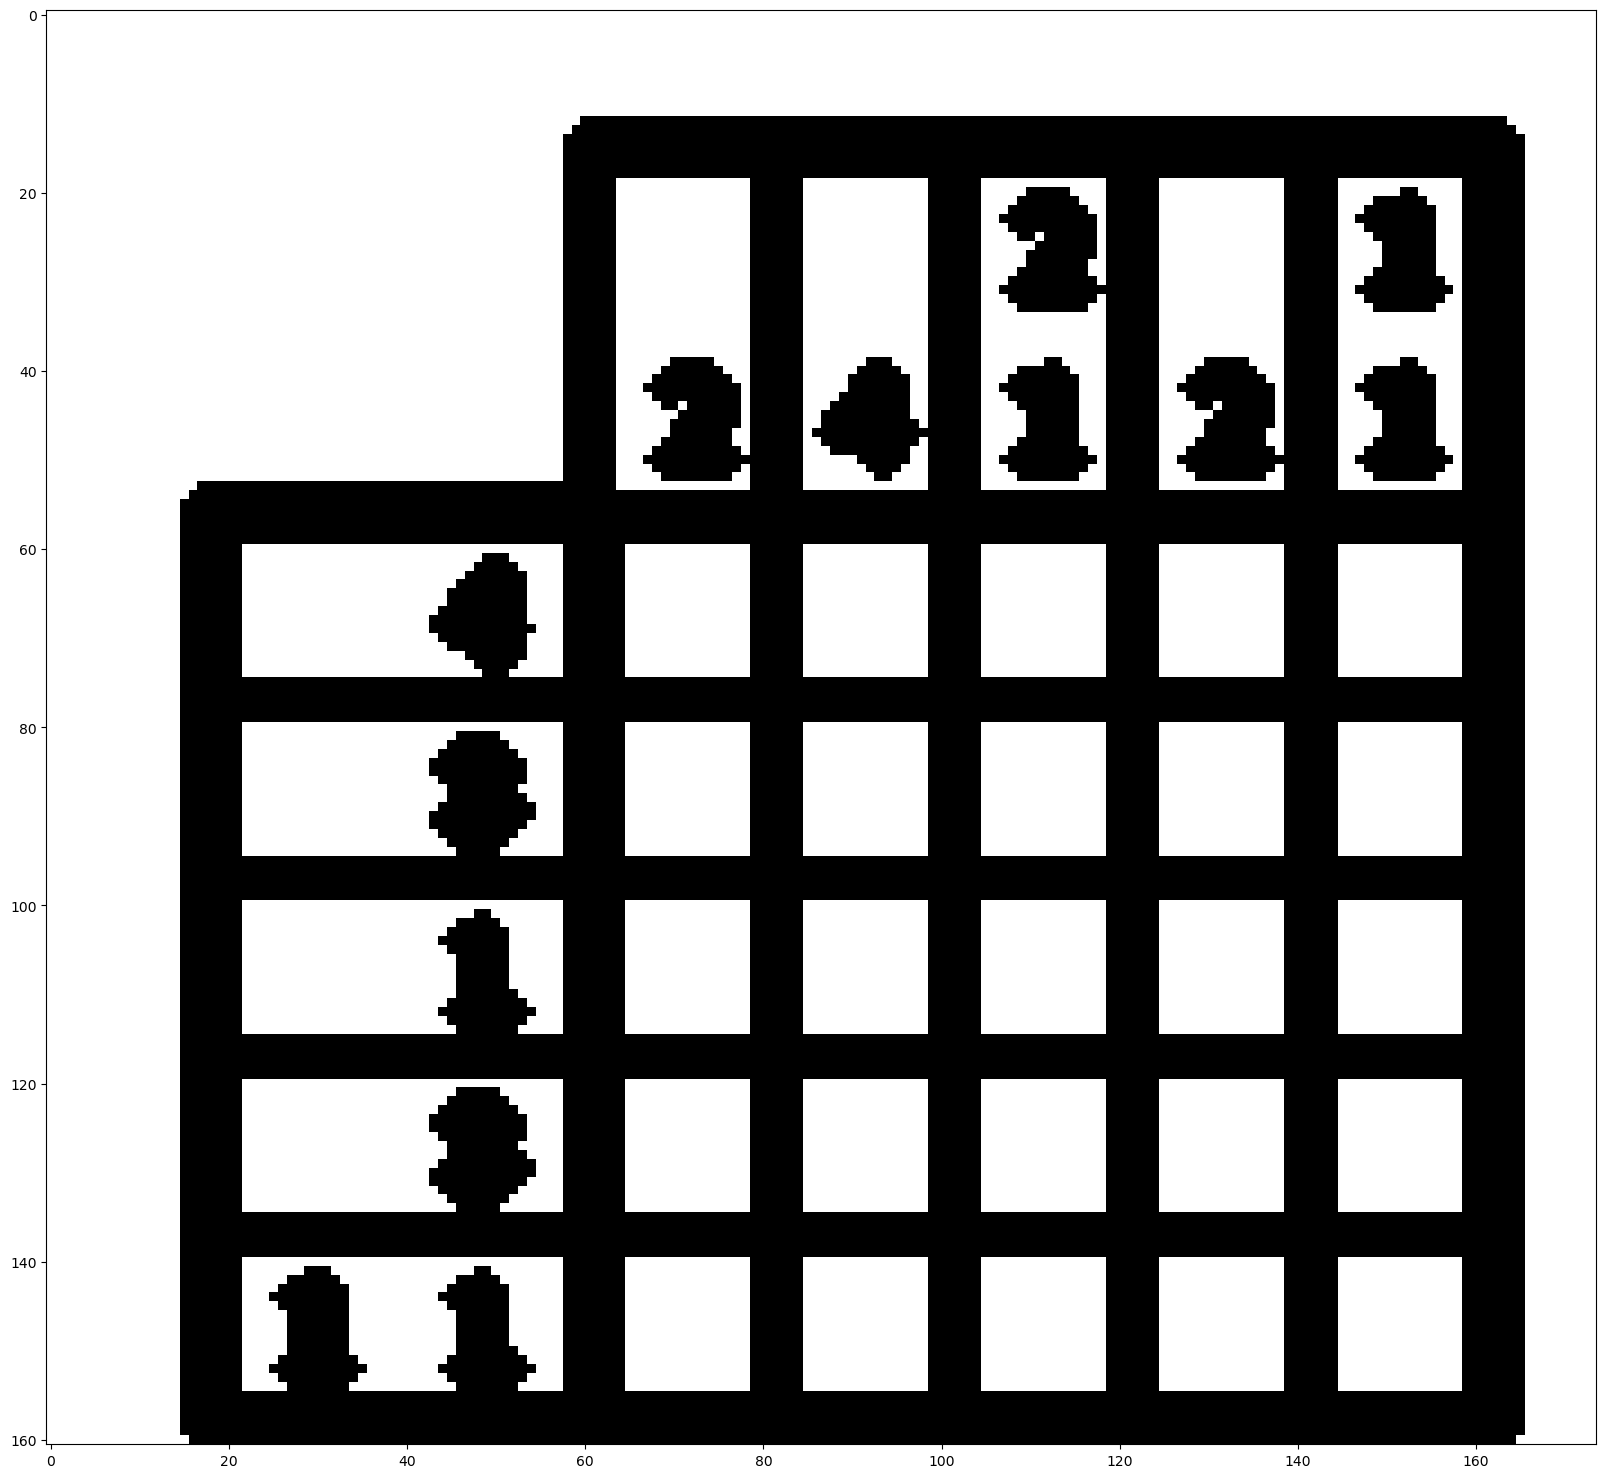

In [52]:
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
_, thresh = cv2.threshold(gray_image, 150, 255, cv2.THRESH_BINARY_INV)
contours, _ = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
newContours = []
for contour in contours:
    if len(contour) > 0:
        epsilon = 0.01 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        print(cv2.contourArea(approx))
        print(approx)        
        print(cv2.contourArea(contour))
        print(contour)
        newContours.append(approx)
imageContours = image_contours.copy()
cv2.drawContours(imageContours, contours, -1, (0, 255, 0), 3)        
pyplot.figure(figsize= (20,20))
pyplot.imshow(imageContours, cmap="gray")
pyplot.show()


In [53]:
outline = newContours[0]

[ 49 151]


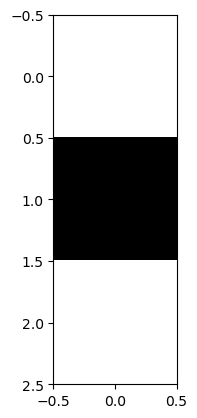

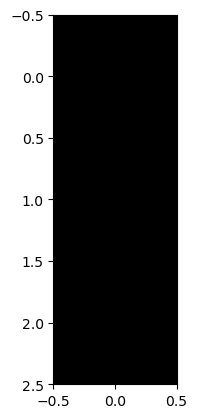

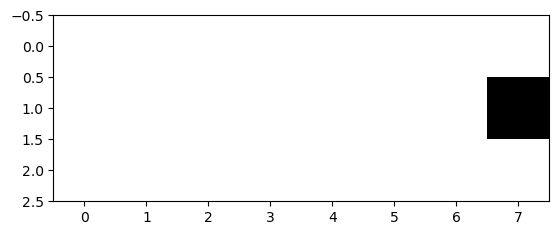

In [54]:
topLeft = (outline.min(axis=0, keepdims=True))[0][0]
bottomRight = outline.max(axis=0, keepdims=True)[0][0]
for pointArray in outline:
    point = pointArray[0]
    if (
            point[0] > topLeft[0] and point[0] < bottomRight[0] and
            point[1] > topLeft[1] and point[1] < bottomRight[1]
        ):
        insidePoint = point
print(insidePoint)
insideImage = image_contours[insidePoint[0]:bottomRight[0], insidePoint[1]:bottomRight[1]]
topSide = image_contours[topLeft[0]:insidePoint[0], insidePoint[1]:bottomRight[1]]
leftSide = image_contours[insidePoint[0]:bottomRight[0], topLeft[1]:insidePoint[1]]

pyplot.imshow(insideImage, cmap="gray")
pyplot.show()
pyplot.imshow(topSide, cmap="gray")
pyplot.show()
pyplot.imshow(leftSide, cmap="gray")
pyplot.show()

# todo check and test :D


# Train model

In [55]:
from keras.models import load_model
# Load the MNIST dataset from OpenCV (this loads pre-trained data)
# This is a convenient way to quickly get started with digit recognition.
def createDigitRecognizer():
    # Load the MNIST dataset
    (train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
    
    # Preprocess the images
    train_images = train_images.astype('float32') / 255
    test_images = test_images.astype('float32') / 255

    # Reshape the images and add a channel dimension
    train_images = np.expand_dims(train_images, axis=-1)
    test_images = np.expand_dims(test_images, axis=-1)

    # One-hot encode the labels
    train_labels = tf.keras.utils.to_categorical(train_labels)
    test_labels = tf.keras.utils.to_categorical(test_labels)
    
    # Build the CNN model
    model = keras.Sequential([
        keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(64, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(10, activation='softmax')
    ])
    
    # Compile the model
    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    # Train the model
    model.fit(train_images, train_labels, epochs=5, batch_size=64, validation_data=(test_images, test_labels))
    return model

import os

import keras.saving
digitRecognizerModelFileName = f"{dataDir}/digitRecognizerMnist.keras"
if (os.path.exists(digitRecognizerModelFileName)):
    digitRecognizer = load_model(digitRecognizerModelFileName)
else:
    digitRecognizer = createDigitRecognizer()
    digitRecognizer.save(f"{dataDir}/digitRecognizerMnist.keras")

# Recognize digits

In [56]:
def extract_digit_image_from_contour(image, contour):
    x, y, w, h = cv2.boundingRect(contour)
    x -= 1
    y -= 1
    w += 2
    h += 2
    bounding_rect = (x, y, w, h)

    if (w > h):
        delta = (w-h)//2
        y -= delta
        h = w
        #digit_image = image[y-delta:y+w-delta, x:x+w]
    else:
        delta = (h-w)//2
        x -= delta
        w = h
        #digit_image = image[y:y+h, x-delta:x+h-delta]
    if (x < 0):
        x = 0
    if (y < 0):
        y = 0
    #if (x + w > image.shape[0]):
    #    x = image.shape[0] - w
    #if (y + h > image.shape[1]):
    #    y = image.shape[1] - h
    
    
    digit_image = image[y:y+h, x:x+w]

    return (digit_image, bounding_rect)

def prepare_digit_image_for_recognition(digit_image):
    digit_image = cv2.resize(digit_image, (28, 28), interpolation=cv2.INTER_AREA)
    digit_image = cv2.GaussianBlur(digit_image, (3,3), 0)
    digit_image = 1-digit_image.reshape(1, 28, 28, 1)
    return digit_image

def recognize_digit_from_image(digit_recognizer, digit_image):
    probabilities = digitRecognizer(digit_image)
    predicted_digit = np.argmax(probabilities)

    #extractor = keras.Model(inputs=digitRecognizer.inputs, outputs=[layer.output for layer in digitRecognizer.layers])
    #intermediate_layer_model = keras.Model(inputs=digitRecognizer.input,
    #                               outputs=digitRecognizer.get_layer("dense_3").output)
    #intermediate_output = intermediate_layer_model(digit_image_resized)
    #print(intermediate_output)

    return (predicted_digit, probabilities)



no digit found: 8 (61, 15, 102, 42) 2.4285714285714284 [[3.50063376e-13 6.00634503e-22 2.86931191e-02 2.80609786e-16
  2.08097094e-06 1.04908474e-19 1.05689105e-16 3.97129988e-05
  9.71265137e-01 3.15109571e-16]]
no digit found: 5 (61, 57, 102, 101) 1.00990099009901 [[6.33193227e-03 1.61957389e-04 1.53259812e-02 3.95890558e-03
  1.09302536e-01 6.15361452e-01 3.27094570e-02 9.24264193e-02
  1.24408923e-01 1.24155886e-05]]
no digit found: 8 (68, 39, 8, 5) 1.6 [[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  1.6034916e-37 5.7136299e-31 0.0000000e+00 1.0000000e+00 0.0000000e+00]]
no digit found: 7 (81, 75, 23, 5) 4.6 [[0.0000000e+00 0.0000000e+00 7.5882034e-25 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 1.0000000e+00 3.0511063e-17 0.0000000e+00]]
no digit found: 7 (81, 95, 23, 5) 4.6 [[0.000000e+00 0.000000e+00 9.044116e-22 0.000000e+00 0.000000e+00
  0.000000e+00 0.000000e+00 1.000000e+00 5.291168e-14 0.000000e+00]]
no digit found: 7 (81, 115, 23, 5)

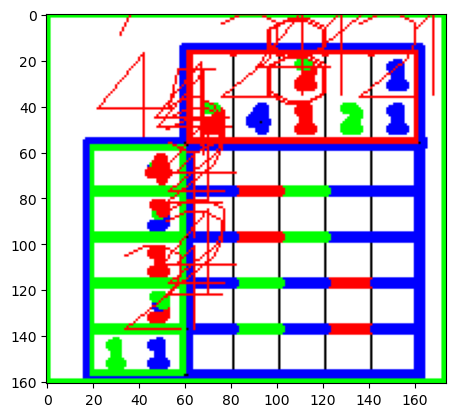

In [57]:
def paint_contours(image, contours):
    colors = [(0,0,255),(0,255,0),(255,0,0)]
    for index, contour in enumerate(contours):
        cv2.drawContours(image, [contour], -1, colors[index % len(colors)], 2)

def recognize_digits(image_contours, image_digits):
    found_contours = []
    image_output = cv2.cvtColor(image_digits, cv2.COLOR_GRAY2BGR)
    
    # Preprocess the image (resize, grayscale, thresholding, etc.)
    contours, _ = cv2.findContours(image_contours.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE )
    paint_contours(image_output, contours)

    for (contour, bounding) in sorted([(contour, cv2.boundingRect(contour))for contour in contours], key=lambda tuple: tuple[1]):
        digit_image, bounding_rect = extract_digit_image_from_contour(image_digits, contour)
        x, y, w, h = bounding_rect

        if (digit_image.size != 0):   # todo add notification we skip because None..
            digit_image = prepare_digit_image_for_recognition(digit_image)
            (predicted_digit, probabilities) = recognize_digit_from_image(digitRecognizer, digit_image)
            predictedProbability = probabilities[0][predicted_digit]

            area = cv2.contourArea(contour)
            aspectRatio = w / h

            if (predictedProbability > .8 and aspectRatio > .15 and aspectRatio < 1.5):# and area < 200):  # magic numbers!
                font = cv2.FONT_HERSHEY_PLAIN
                cv2.putText(image_output, str(predicted_digit), (x, y), font, 4, (255, 0, 0))
                found_contours.append((bounding_rect, predicted_digit, digit_image))
            else:
                print(f"no digit found: {predicted_digit} {bounding_rect} {aspectRatio} {probabilities}")
                found_contours.append((bounding_rect, None, digit_image))

    pyplot.imshow(image_output, cmap="gray")
    return found_contours

found_contours = recognize_digits(image_contours, image_digits)

remove (-1, -1, 176, 163) 7
remove (16, 13, 150, 148) 7
remove (18, 57, 43, 101) 4
remove (44, 65, 5, 5) 4
remove (45, 64, 5, 5) 5
remove (46, 85, 6, 5) 4
remove (46, 125, 6, 5) 4
remove (61, 15, 102, 42) None
remove (61, 57, 102, 101) None
remove (68, 39, 8, 5) None
remove (81, 75, 23, 5) None
remove (81, 95, 23, 5) None
remove (81, 115, 23, 5) None
remove (81, 135, 23, 5) None
remove (88, 43, 5, 5) 8
remove (89, 42, 5, 5) 8
remove (101, 75, 23, 5) None
remove (101, 95, 23, 5) None
remove (101, 115, 23, 5) None
remove (101, 135, 23, 5) None
remove (108, 20, 8, 5) None
remove (121, 75, 23, 5) None
remove (121, 95, 23, 5) None
remove (121, 115, 23, 5) None
remove (121, 135, 23, 5) None
remove (128, 39, 8, 5) None
15
[((26, 141, 9, 14), 2), ((43, 61, 12, 14), 4), ((44, 86, 10, 9), 2), ((44, 101, 10, 14), 1), ((44, 126, 10, 9), 2), ((44, 141, 10, 14), 1), ((45, 81, 9, 8), 2), ((45, 121, 9, 8), 2), ((68, 40, 10, 13), 2), ((87, 39, 11, 14), 4), ((108, 21, 10, 13), 2), ((108, 39, 10, 14), 1)

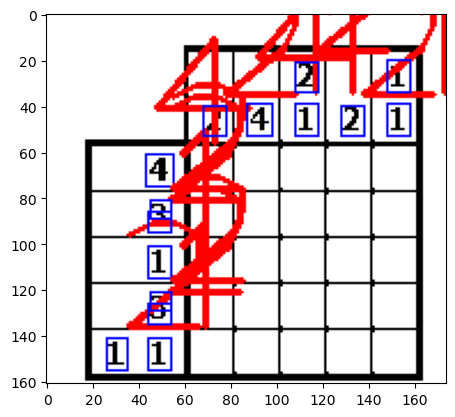

In [58]:
def removeOverlappingDigits(found_contours):
    result = []
    maxArea = 1000  # todo magic number

    for (boundingRect, digit, digit_image) in found_contours:
        hasOverlap = False
        for (otherBoundingRect, other_digit, _) in found_contours:
            overlapRect = (
                max(boundingRect[0], otherBoundingRect[0]), 
                max(boundingRect[1], otherBoundingRect[1]),
                min(boundingRect[0] + boundingRect[2], otherBoundingRect[0] + otherBoundingRect[2]), 
                min(boundingRect[1] + boundingRect[3], otherBoundingRect[1] + otherBoundingRect[3])
            )
            w = overlapRect[2] - overlapRect[0]
            h = overlapRect[3] - overlapRect[1]
            if (w > 0 and h > 0 and boundingRect != otherBoundingRect and other_digit != None and (otherBoundingRect[2] * otherBoundingRect[3] < maxArea)):
                overlap = w*h
                area = boundingRect[2]*boundingRect[3]
                if (overlap/area > .5):      # magic number!    # todo make sure we don't overlap slightly overlapping contours? (prob not possible)
                    hasOverlap = True
        
        if (not hasOverlap and digit != None and (boundingRect[2] * boundingRect[3] < maxArea)):
            result.append((boundingRect, digit, digit_image))
        else:
            print(f"remove {boundingRect} {digit}")

    return result

found_contours_no_overlaps = removeOverlappingDigits(found_contours)

imageOutput = image_digits.copy()
imageOutput = cv2.cvtColor(imageOutput, cv2.COLOR_GRAY2BGR)
for (boundingRect, digit, digit_image) in found_contours_no_overlaps:
    cv2.putText(imageOutput, str(digit), (boundingRect[0], boundingRect[1]),  cv2.FONT_HERSHEY_PLAIN, 5, (255, 0, 0), 2)
    (x, y, w, h) = boundingRect
    cv2.rectangle(imageOutput, (x, y), (x+w,y+h), (0,0,255))
pyplot.imshow(imageOutput)
print(len(found_contours_no_overlaps))
print([(bounding_rect, digit) for bounding_rect, digit, _ in found_contours_no_overlaps])

4


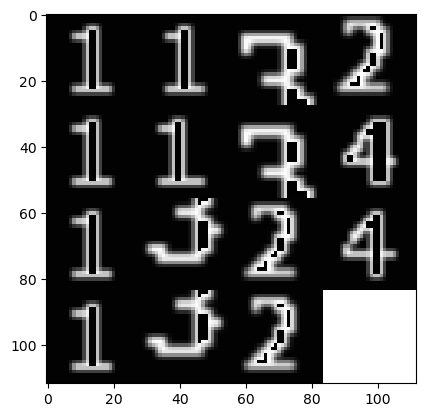

In [59]:
import math
def showImagesUsedForRecognition(found_contours, sort_by_prediction):
    imageSize = math.ceil(len(found_contours) ** .5)
    imageOutput = np.ones((imageSize * 28, imageSize * 28, 1), dtype=np.uint8) * 255

    x = 0
    y = 0

    contours_to_show = found_contours if not sort_by_prediction else sorted(found_contours, key= lambda tuple: tuple[1])
    for _, _, digit_image in contours_to_show:
        imageOutput[x*28:x*28+28, y*28:y*28+28] = digit_image
        x += 1
        if (x >= imageSize):
            x = 0
            y += 1

    print(imageSize)
    pyplot.imshow(imageOutput, cmap="gray")
showImagesUsedForRecognition(found_contours_no_overlaps, sort_by_prediction=True)

In [60]:
foundDigits = [(bounding_rect, digit) for (bounding_rect, digit, digit_image) in found_contours_no_overlaps]
import determineTable

(A, alpha, B, beta) = grid_parameters = determineTable.findParameters(foundDigits)
(lefties, toppies) = determineTable.divideOverLeftAndTop(foundDigits, A, alpha, B, beta)

In [61]:
'''
import matplotlib.pyplot


A = 70; alpha = 20
B = 70; beta = 20

def computeCosts(A, alpha):
    costs = 0
    for (center, value) in foundDigits:
        predictionX  = round((center[0] - A) / alpha)
        predictionY = round((center[1] - B) / beta)
        costsX = (predictionX - center[0]) ** 2
        costsY = (predictionY - center[1]) ** 2
        #print(center, costsX, costsY)
        costs += costsX
    return costs

As = np.arange(60, 80, 1)
alphas = np.arange(10, 30, 1)
X, Y = np.meshgrid(As, alphas)
Z = np.vectorize(computeCosts)(X, Y)

fig, ax = matplotlib.pyplot.subplots(subplot_kw={"projection": "3d"})
# Plot the surface.
surf = ax.plot_surface(X, Y, Z)
'''
'''
As = np.arange(60, 80, 1)
alphas = np.arange(10, 30, 1)
X, Y = np.meshgrid(As, alphas)
Z = np.vectorize(computeCosts)(X, Y)

fig, ax = matplotlib.pyplot.subplots(subplot_kw={"projection": "3d"})
# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=matplotlib.cm.coolwarm,
                       linewidth=0, antialiased=False)
#from matplotlib.ticker import LinearLocator
# Customize the z axis.
ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(matplotlib.ticker.LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

#matplotlib.pyplot.show()
'''

'\nAs = np.arange(60, 80, 1)\nalphas = np.arange(10, 30, 1)\nX, Y = np.meshgrid(As, alphas)\nZ = np.vectorize(computeCosts)(X, Y)\n\nfig, ax = matplotlib.pyplot.subplots(subplot_kw={"projection": "3d"})\n# Plot the surface.\nsurf = ax.plot_surface(X, Y, Z, cmap=matplotlib.cm.coolwarm,\n                       linewidth=0, antialiased=False)\n#from matplotlib.ticker import LinearLocator\n# Customize the z axis.\nax.set_zlim(-1.01, 1.01)\nax.zaxis.set_major_locator(matplotlib.ticker.LinearLocator(10))\n# A StrMethodFormatter is used automatically\nax.zaxis.set_major_formatter(\'{x:.02f}\')\n\n# Add a color bar which maps values to colors.\nfig.colorbar(surf, shrink=0.5, aspect=5)\n\n#matplotlib.pyplot.show()\n'

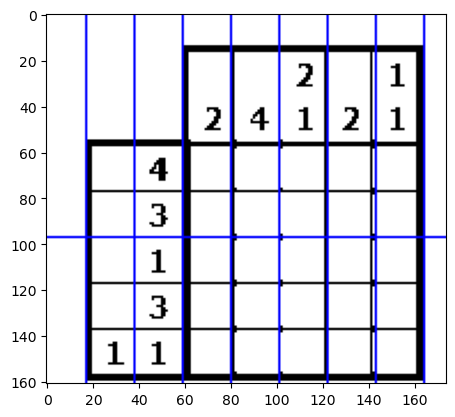

In [62]:
def addAxesFoundToImage(image, parameters):
    (A, alpha, B, beta) = parameters
    imageCopy = image.copy()
    imageCopy = cv2.cvtColor(imageCopy, cv2.COLOR_GRAY2BGR)
    for i in range(-200, 200):
        y = A + alpha * i + alpha//2
        x = B + beta * i + beta//2
        cv2.line(imageCopy, (0, x), (2000, x), (0,0,255))
        cv2.line(imageCopy, (y, 0), (y, 2000), (0,0,255))

    pyplot.imshow(imageCopy)

addAxesFoundToImage(image_digits, grid_parameters)# (141, 56, 142, 57))# (49, 21, 67, 21))
#addAxesFoundToImage(image_digits, (271, 25, 140, 28))# (271, 25, 140, 28) the correct parameters for sample4


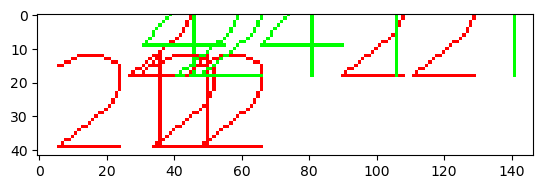

In [63]:
def create_grid_image(lefties, toppies, grid_cell_size):
    grid_columns = [tuple[0][0] for tuple in lefties + toppies]
    grid_rows = [tuple[0][1] for tuple in lefties + toppies]
    grid_bounding_rect = (min(grid_columns), min(grid_rows), max(grid_columns)-min(grid_columns)+1, max(grid_rows)-min(grid_rows)+1)
    grid_image = np.ones((grid_bounding_rect[3] * grid_cell_size, grid_bounding_rect[2] * grid_cell_size, 3), dtype=np.uint8) * 255
    grid_cell_digits = {}

    font = cv2.FONT_HERSHEY_PLAIN
    for ((row, column), bounding_rect, digit) in lefties:
        grid_cell_digits.setdefault((row, column), []).append((bounding_rect, digit, "left"))
    for ((row, column), bounding_rect, digit) in toppies:
        grid_cell_digits.setdefault((row, column), []).append((bounding_rect, digit, "top"))

    #    cv2.putText(grid_image, str(digit), ((row - grid_bounding_rect[0]) * grid_cell_size, (column + 1 - grid_bounding_rect[1]) * grid_cell_size), font, 2, (255, 0, 0), 3)
    #for (row, column, digit) in toppies:
    #    cv2.putText(grid_image, str(digit), ((row - grid_bounding_rect[0]) * grid_cell_size, (column + 1 - grid_bounding_rect[1]) * grid_cell_size), font, 2, (0, 255, 0), 3)

    for ((row, column), digits) in grid_cell_digits.items():
        for (digit_index, (bounding_rect, digit, group)) in enumerate(digits):
            color = (255, 0, 0) if group == "left" else (0, 255, 0)
            text_point = (row - grid_bounding_rect[0]) * grid_cell_size + digit_index * grid_cell_size//3, (column + 1 - grid_bounding_rect[1]) * grid_cell_size
            cv2.putText(grid_image, str(digit), text_point, font, 3, color)

    return grid_image

pyplot.imshow(create_grid_image(lefties, toppies, alpha))